In [ ]:
# NEW SATLAS inference tests on single image Sentinel-2 image of Alas Mertajati
# Sept 2024
# References:
# https://huggingface.co/allenai/satlas-pretrain
# https://github.com/allenai/satlas/

# Preparation:
# 1. Get image from Copernicus via openEO
# https://openeo.org/
# https://openeo.org/documentation/1.0/python/
# 2. Define input image
# 3. Create image stack from input .tif and save as a numpy array (.npy)
# 4. Get SatLas pretrained models and configurations from Huggingface
# # !wget https://huggingface.co/allenai/satlas-pretrain/blob/main/sentinel2_resnet152_si_ms.pth
#---------------------------------------------------------------------------

import sys
from google.colab import drive
drive.mount('/content/drive')
# adjust to your configuration
root = '/content/drive/MyDrive/Colab/research/'
datapath = root + "data/"
#link to satlas installed files
sys.path.append(root +'code/')
sys.path.append(root +'code/satlas/')
sys.path.append(root +'code/satlas/model/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from compute_resources import *

In [ ]:
# Check if compute resources
print(check_cloud_run())
# Check for GPU
print(check_gpu())
# Check CPU
print(check_cpu())
# Check available memory
memory = psutil.virtual_memory()
print(f"Available memory: {memory.available / (1024 * 1024 * 1024):.2f} GB")

0 - Not running on Google Cloud Run
GPU detected: Tesla T4
CPU detected: x86_64 (x86_64) - 1 cores, 2 threads
Available memory: 11.31 GB


In [ ]:
!pip install rasterio
!pip install vit-pytorch

In [ ]:
# works
non_cropped_input = datapath + "openEO_2023-09-09Z-8bit-RGBstack.npy"
cropped_output = non_cropped_input.split('.npy')[0]  + "-cropped.npy"
print(cropped_output)

# works
#non_cropped_input = datapath + "openEO_2023-09-09Z-8bit-RGBstack-v2.npy"
#cropped_output = non_cropped_input.split('.npy')[0]  + "-cropped.npy"
#print(cropped_output)

/content/drive/MyDrive/Colab/research/data/openEO_2023-09-09Z-8bit-RGBstack-cropped.npy


In [ ]:
import rasterio
from rasterio.windows import Window
import numpy as np
import os
from IPython.display import display, Image

In [ ]:
image_stack = np.load(non_cropped_input)
square_size = 1024

In [ ]:
#if only one image:
num_images = 1
num_bands, height, width = image_stack.shape
square_images = np.zeros((num_images, num_bands, square_size, square_size))

crop_height = (height - square_size) // 2
crop_width = (width - square_size) // 2
square_images = image_stack[:, crop_height:crop_height+square_size, crop_width:crop_width+square_size]

new_square_images = np.array(square_images, dtype=image_stack.dtype)  # Use the same data type as input
print(new_square_images.shape)

(3, 1024, 1024)


In [ ]:
np.save(cropped_output, new_square_images)

In [ ]:
image_stack = np.load(non_cropped_input)
print("Original: ", image_stack.shape)

print(len(image_stack.shape))
type(image_stack)

cropped_image = np.load(cropped_output)
print("Cropped: ", cropped_image.shape)
type(cropped_image)

Original:  (3, 1204, 1378)
3
Cropped:  (3, 1024, 1024)


numpy.ndarray

In [ ]:
import os, glob
import zipfile
from pathlib import Path

In [ ]:
#model = "sentinel2_resnet152_mi_ms.pth"
#config = "resnet152_mi_ms.txt"

model = "sentinel2_resnet152_si_rgb.pth"
config = "resnet152_si_rgb.txt"


In [ ]:
image_npy = cropped_output

weights_path = datapath + model
config_path = datapath + config
image_path = image_npy

In [ ]:
import json
import numpy
import skimage.io
import torch
import tqdm
import time

In [ ]:
# importing satlas in colab not working
# alternate approach

In [ ]:
os.chdir('/content/drive/MyDrive/Colab/research/code/satlas/')
!pwd

/content/drive/MyDrive/Colab/research/code/satlas


In [ ]:
from classify import *
from util import *
from dataset import *       # commented out import satlas.util
from model import *         # commented out import satlas.model
from evaluate import *      # commented out import satlas.util

In [ ]:
with open(config_path, 'r') as f:
    config = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ", device)

for spec in config['Tasks']:
    if 'Task' not in spec:
        #spec['Task'] = satlas.model.dataset.tasks[spec['Name']]
        spec['Task'] = tasks[spec['Name']]

Device is:  cuda


In [ ]:
print(spec)

{'Name': 'snow', 'Metric': 'accuracy', 'LabelDir': 'satlas_root/datasets/lowres/', 'TrainSplit': 'satlas_root/metadata/train_event_train.json', 'ValSplit': 'satlas_root/metadata/train_event_val.json', 'TestSplit': 'satlas_root/metadata/test_event.json', 'Task': {'type': 'classification', 'categories': ['no', 'partial', 'yes']}}


In [ ]:
print("\nGot confing and device")
#model = satlas.model.model.Model({'config': config['Model'],'channels': config['Channels'],'tasks': config['Tasks'],})
model = Model({'config': config['Model'],'channels': config['Channels'],'tasks': config['Tasks'],})
print("\nGot the model")
state_dict = torch.load(weights_path, map_location=device)
print("\nGot state_dict")
model.load_state_dict(state_dict)
print("\nModel loaded")
model.to(device)
print("\nModel to device")
print("trainable parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("\nEvaluating")
model.eval()

In [ ]:
image = numpy.load(image_path)
# For (N, C, H, W) image (with N timestamps), convert to (N*C, H, W).
#image = image.reshape(image.shape[0]*image.shape[1], image.shape[2], image.shape[3])

# The image is large so apply it on windows.
# Here we collect outputs from head 0 which is the only head of the config (tree cover).
vis_output = numpy.zeros((image.shape[1], image.shape[2], 3), dtype=numpy.uint8)
crop_size = 1024
head_idx = 0

In [ ]:
print(image.shape)

(3, 1024, 1024)



Inference


  0%|          | 0/1 [00:00<?, ?it/s]


Row  0
Column  0

Passing crop section to the model..


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Moving to evaluate.

Finished evaluating.
crop shape length is NOT 2

Downloading:  /content/drive/MyDrive/Colab/research/data/openEO_2023-09-09Z-8bit-RGBstack-v2-cropped_rgb.png /content/drive/MyDrive/Colab/research/data/openEO_2023-09-09Z-8bit-RGBstack-v2-cropped.jpg

 0 



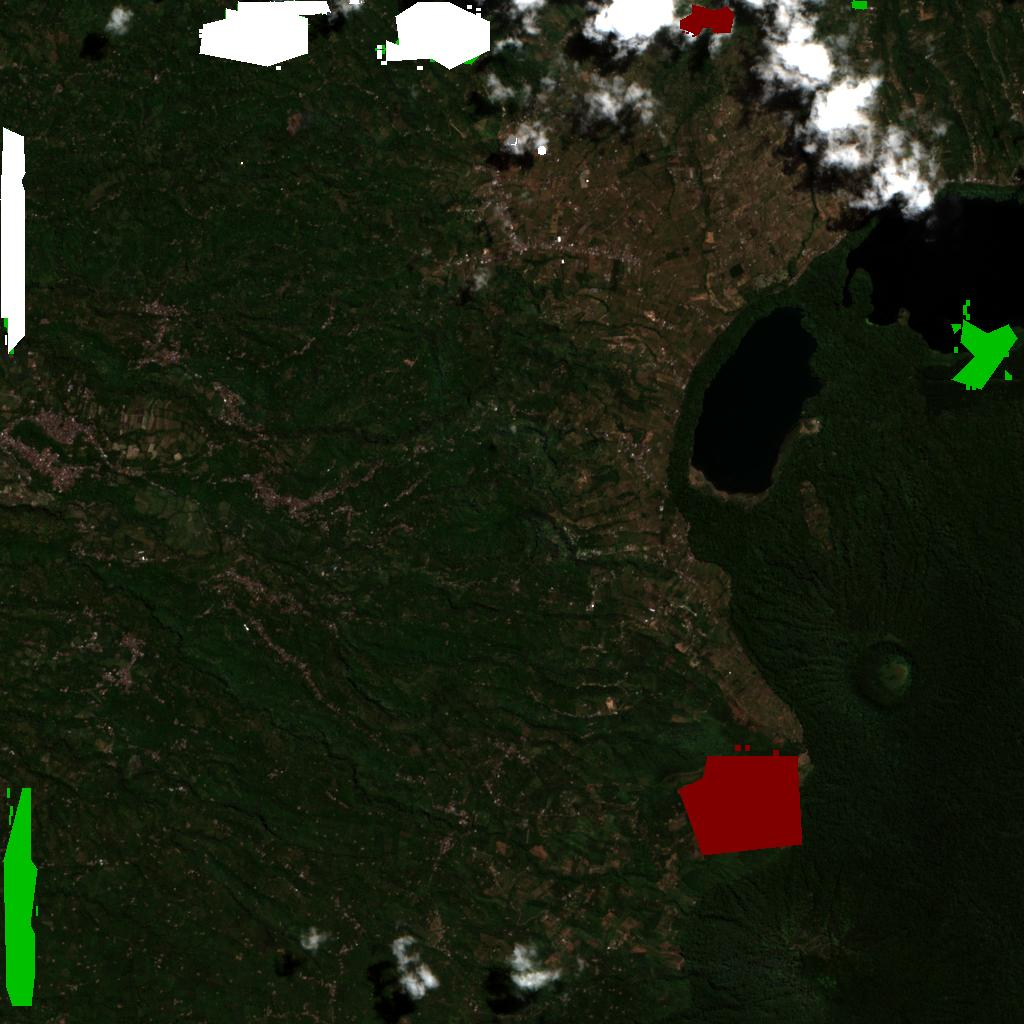

Image Saved

Inference


  0%|          | 0/1 [00:00<?, ?it/s]


Row  0
Column  0

Passing crop section to the model..


  0%|          | 0/1 [00:00<?, ?it/s]



Moving to evaluate.

Head_idx error:  1

Inference


  0%|          | 0/1 [00:00<?, ?it/s]


Row  0
Column  0

Passing crop section to the model..


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Moving to evaluate.

Finished evaluating.
crop shape length is NOT 2

Downloading:  /content/drive/MyDrive/Colab/research/data/openEO_2023-09-09Z-8bit-RGBstack-v2-cropped_rgb.png /content/drive/MyDrive/Colab/research/data/openEO_2023-09-09Z-8bit-RGBstack-v2-cropped.jpg

 2 



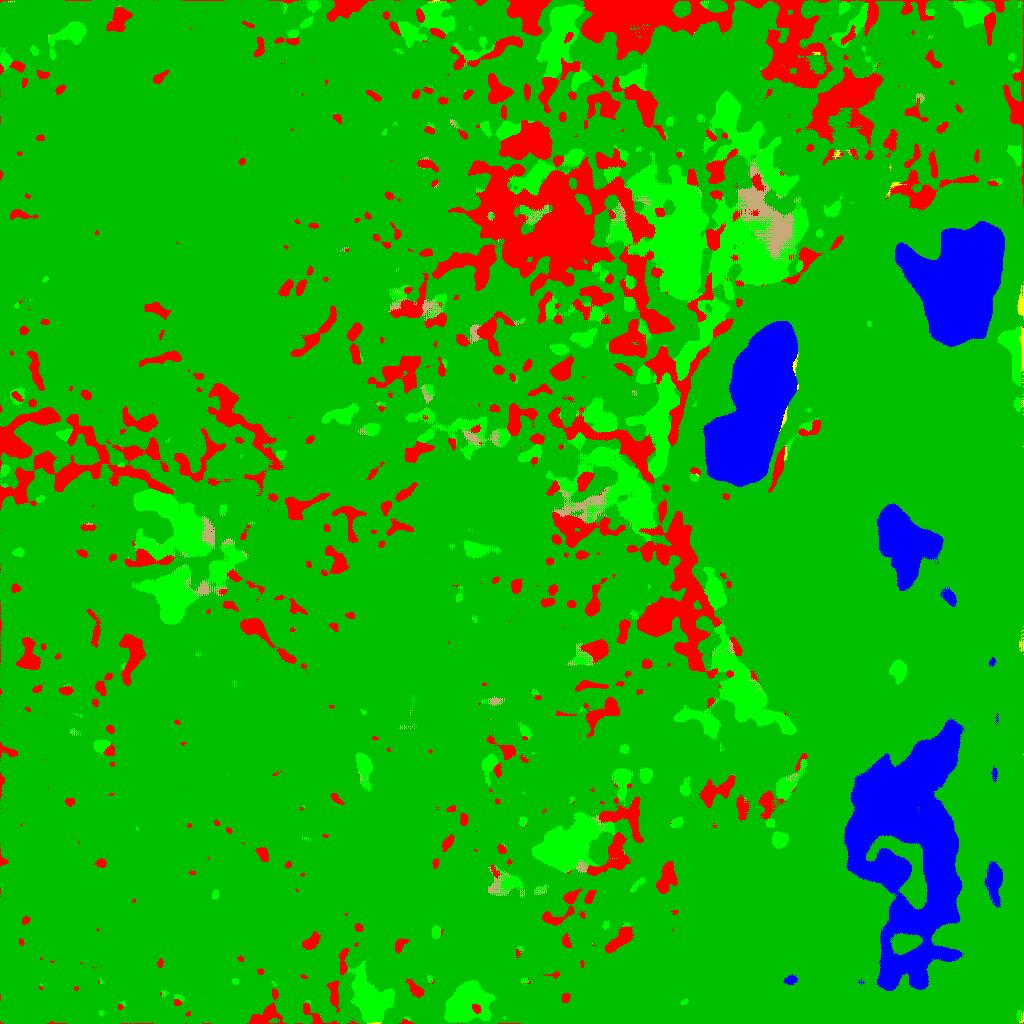

Image Saved

Inference


  0%|          | 0/1 [00:00<?, ?it/s]


Row  0
Column  0

Passing crop section to the model..


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Moving to evaluate.

Finished evaluating.
crop shape length is NOT 2

Downloading:  /content/drive/MyDrive/Colab/research/data/openEO_2023-09-09Z-8bit-RGBstack-v2-cropped_rgb.png /content/drive/MyDrive/Colab/research/data/openEO_2023-09-09Z-8bit-RGBstack-v2-cropped.jpg

 3 




<ipython-input-45-bf61a045294c>:43: UserWarning: /content/drive/MyDrive/Colab/research/data/openEO_2023-09-09Z-8bit-RGBstack-v2-cropped.jpg is a low contrast image
  skimage.io.imsave(fimage, vis_output)


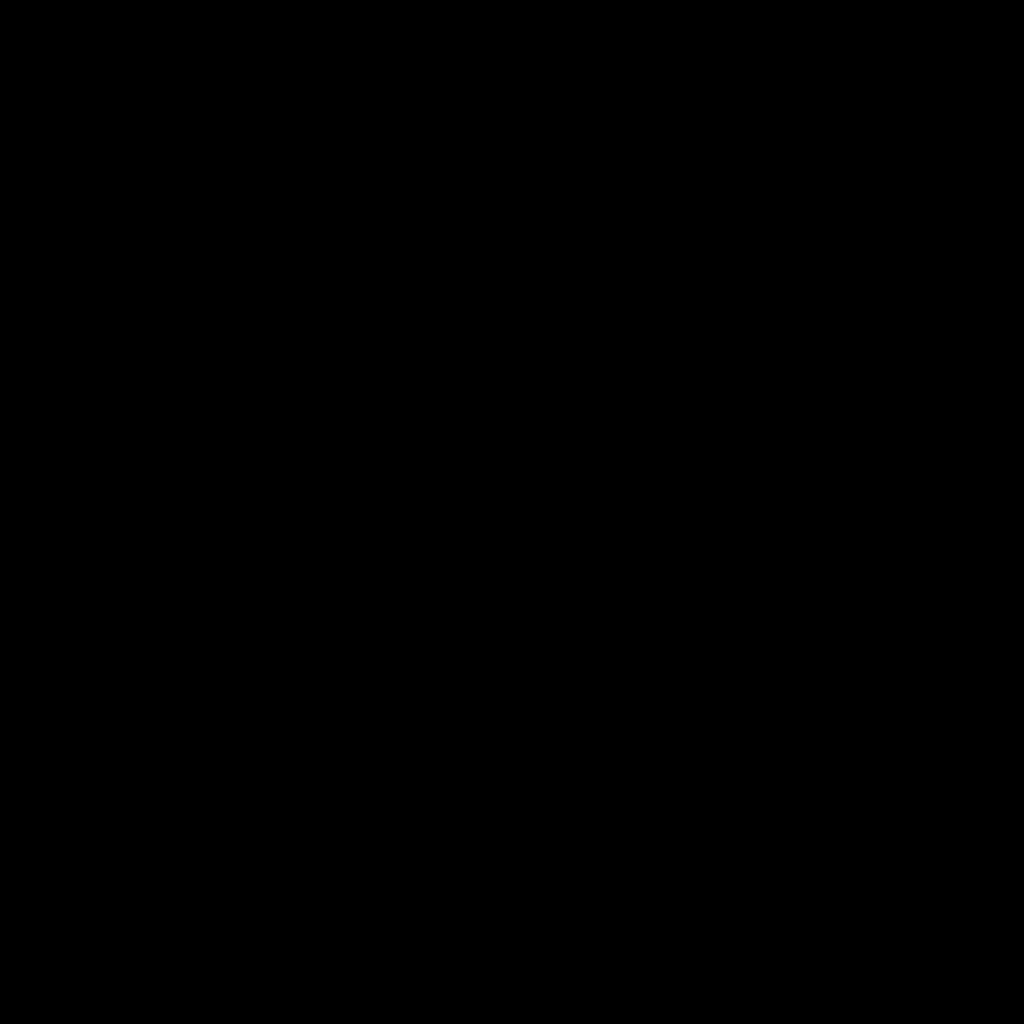

Image Saved

Inference


  0%|          | 0/1 [00:00<?, ?it/s]


Row  0
Column  0

Passing crop section to the model..


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Moving to evaluate.

Finished evaluating.
crop shape length is 2

Downloading:  /content/drive/MyDrive/Colab/research/data/openEO_2023-09-09Z-8bit-RGBstack-v2-cropped_rgb.png /content/drive/MyDrive/Colab/research/data/openEO_2023-09-09Z-8bit-RGBstack-v2-cropped.jpg

 4 



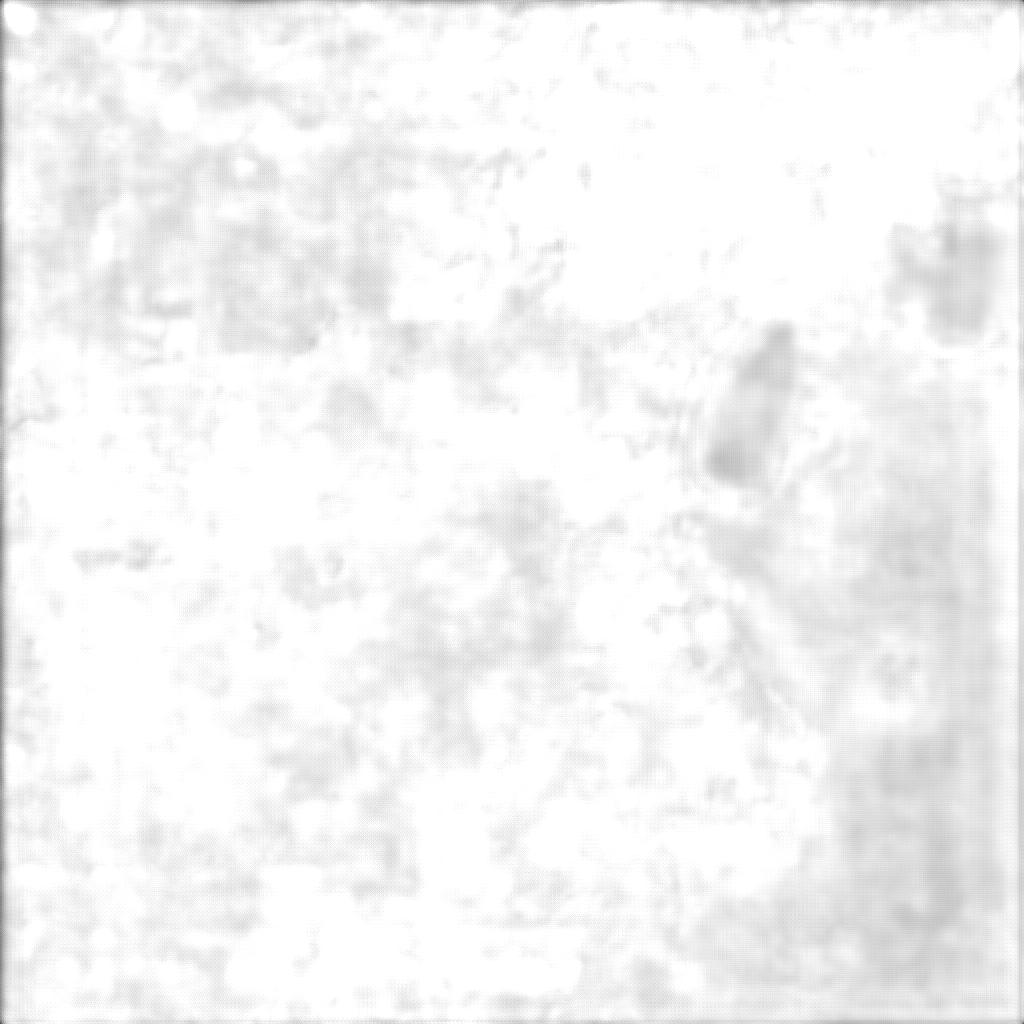

Image Saved

Inference


  0%|          | 0/1 [00:00<?, ?it/s]


Row  0
Column  0

Passing crop section to the model..


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Moving to evaluate.

Finished evaluating.
crop shape length is NOT 2

Downloading:  /content/drive/MyDrive/Colab/research/data/openEO_2023-09-09Z-8bit-RGBstack-v2-cropped_rgb.png /content/drive/MyDrive/Colab/research/data/openEO_2023-09-09Z-8bit-RGBstack-v2-cropped.jpg

 5 



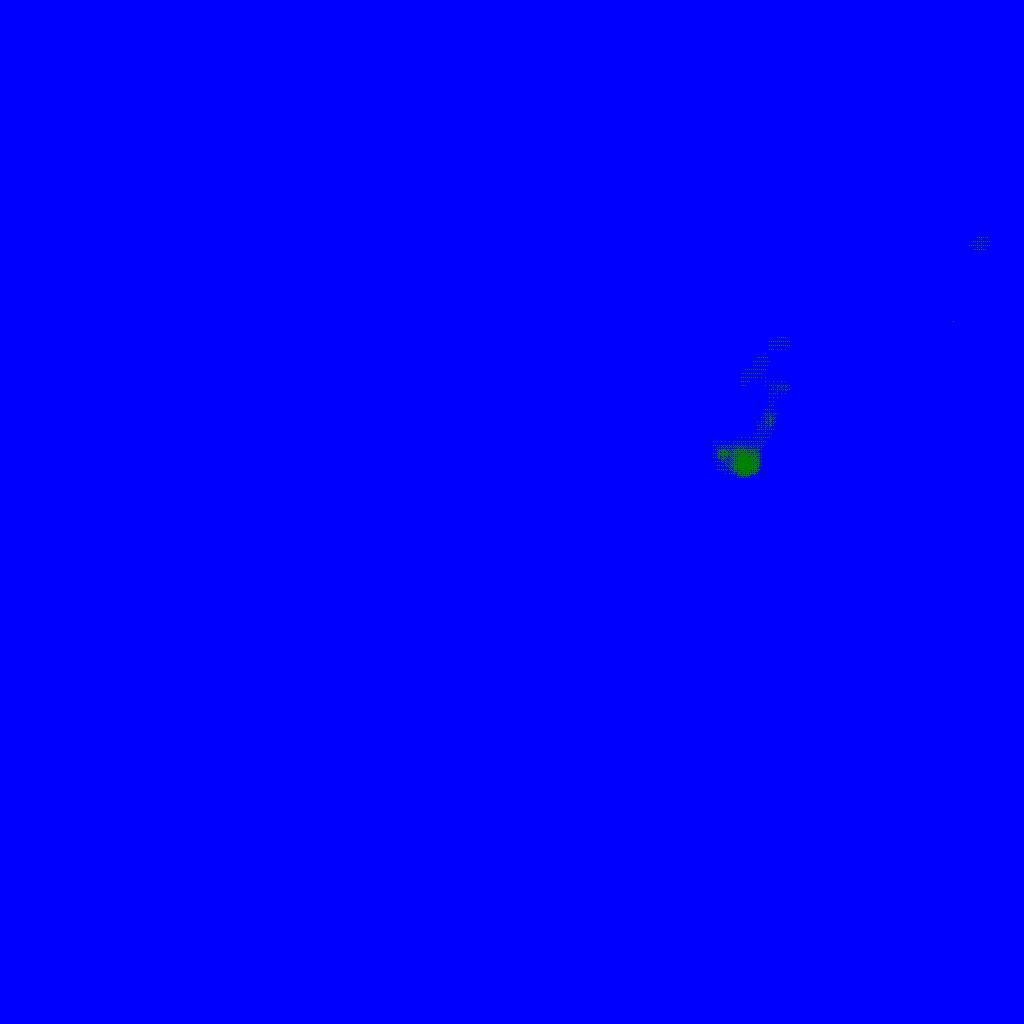

Image Saved


In [ ]:
heads = [0,1,2,3,4,5]

for head_idx in heads:
    try:
        print("\nInference")
        with torch.no_grad():
            for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
                print()
                print("Row ", row)
                for col in range(0, image.shape[2], crop_size):
                    print("Column ", col)
                    crop = image[:, row:row+crop_size, col:col+crop_size]
                    vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
                    gpu_crop = torch.as_tensor(crop).to(device).float() / 255
                    print("\nPassing crop section to the model..")
                    outputs, _ = model([gpu_crop])
                    print("\nMoving to evaluate.")
                    #vis_output_crop, _, _, _ = satlas.model.evaluate.visualize_outputs(
                    vis_output_crop, _, _, _ = visualize_outputs(
                        task=config['Tasks'][head_idx]['Task'],
                        image=vis_crop,
                        outputs=outputs[head_idx][0],
                        return_vis=True,)

                print("\nFinished evaluating.")
                if len(vis_output_crop.shape) == 2:
                    print('crop shape length is 2')
                    vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
                    vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
                    vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
                else:
                    print('crop shape length is NOT 2')
                    vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop


        fimage_rgb =  image_npy.split('.npy')[0] + '_rgb.png'
        fimage = image_npy.split('.npy')[0] + '.jpg'

        try:
            print('\nDownloading: ', fimage_rgb, fimage)
            #skimage.io.imsave(datapath + fimage_rgb, image[0:3, :, :].transpose(1, 2, 0))
            #skimage.io.imsave(datapath + fimage, vis_output)
            skimage.io.imsave(fimage, vis_output)
            print("\n", head_idx, "\n")
            #display(Image(filename=datapath + fimage))
            display(Image(filename=fimage))
            print("Image Saved")
        except:
            print('/nError saving image results')
        # --------------------------------------------------------------------------------------------

    except:
        print("\nHead_idx error: ", head_idx)